## Siler analytics - social media

Fonte de dados: PostgreSQL (tabela silver.user)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import warnings

warnings.filterwarnings('ignore', category=UserWarning, message='.*SQLAlchemy.*')

In [5]:
DB_CONFIG = {
    'host': 'localhost',
    'port': 5433,
    'database': 'social_media',
    'user': 'postgres',
    'password': 'postgres'
}

conn = psycopg2.connect(**DB_CONFIG)

df_silver = pd.read_sql_query("""
    SELECT 
        user_id, age, gender, country, urban_rural, income_level, 
        employment_status, relationship_status, exercise_hours_per_week, 
        sleep_hours_per_night, diet_quality, smoking, alcohol_frequency, 
        perceived_stress_score, self_reported_happiness, body_mass_index, 
        blood_pressure_systolic, blood_pressure_diastolic, 
        daily_steps_count, weekly_work_hours, social_events_per_month, 
        books_read_per_year, volunteer_hours_per_month, 
        daily_active_minutes_instagram, reels_watched_per_day, 
        stories_viewed_per_day, ads_viewed_per_day, ads_clicked_per_day, 
        time_on_feed_per_day, time_on_explore_per_day, 
        time_on_reels_per_day, followers_count, following_count, 
        content_type_preference, preferred_content_theme, 
        user_engagement_score
    fROM silver.user """,conn)

print(f"✓ {len(df_silver):,} registros carregados do PostgreSQL")

✓ 416,183 registros carregados do PostgreSQL


## Regras de negocio

Nosso power BI tem como objetivo mostrar padrões e gostos de usuários do instagram com o objetivo de marcar possiveis publicos para a divulgação de planos de saûde, academia e outros serviços relacionados a saûde fisica dos usuarios.

Trabalharemos apenas com os países do continente americano dentro da base de dados usada (Brasil,Canada e Estados Unidos) e com usuarios maiores de idade

## Porcentagem de usuarios por país

Para saber onde devemos concentrar os investementos de divulgação foi feito um grafico com a porcentagem de usuarios de cada pais 

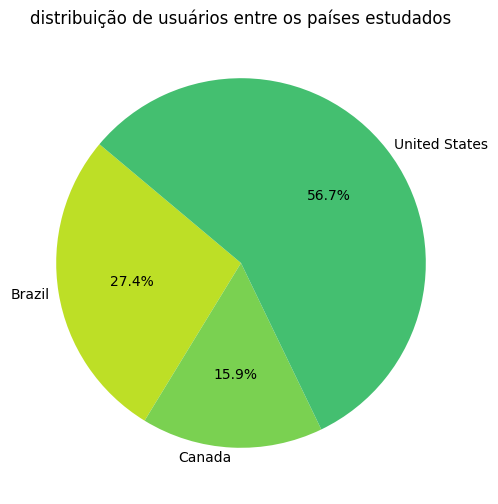

In [3]:
paises_count = df_silver.groupby('country').country.count()
plt.figure(figsize=(10,6))
plt.pie(paises_count, autopct='%1.1f%%', startangle=140,labels= paises_count.index,colors = plt.cm.viridis(np.linspace(0.9, 0, 10)), labeldistance=1.05)
plt.title('distribuição de usuários entre os países estudados')
plt.show()

## Faixa étaria de cada país

Para enteder melhor a maioria do publico de cada pais, foram feitos histogramas da faixa etaria agrupadas por seu país.

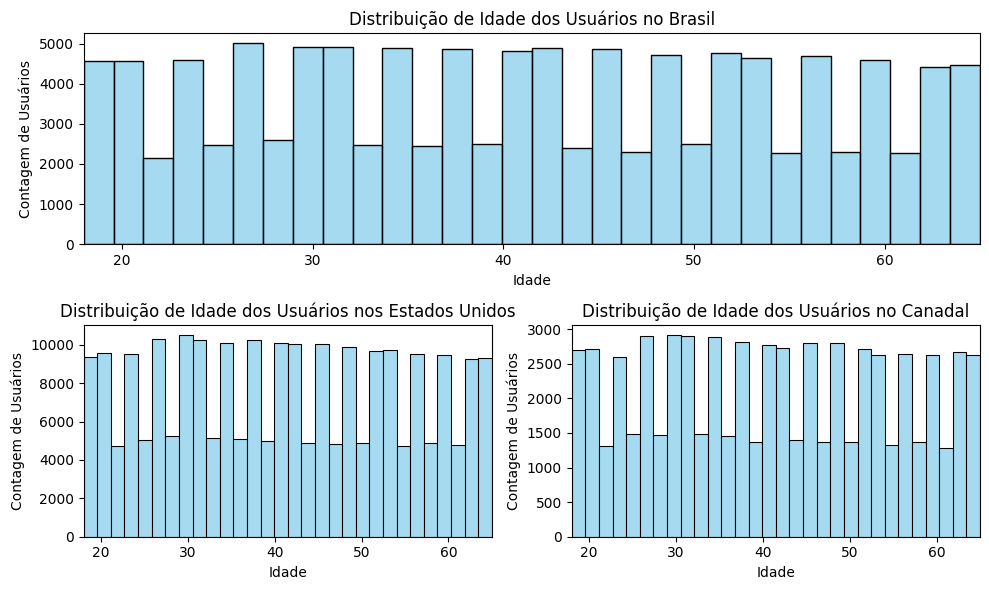

In [ ]:
df_BR = df_silver[df_silver['country'] == 'Brazil']
df_EUA = df_silver[df_silver['country'] == 'United States']
df_CN = df_silver[df_silver['country'] == 'Canada']
idade_count = df_silver.groupby('age').age.count()
fig = plt.figure(figsize=(10,6))
grid = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(grid[0,:])
ax2 = fig.add_subplot(grid[1, 0])
ax3 = fig.add_subplot(grid[1, 1])

grafBR = sns.histplot(data=df_BR, x='age',  color='skyblue',ax = ax1, bins=30)
grafBR.set_title('Distribuição de Idade dos Usuários no Brasil')
grafBR.set_xlabel('Idade')
grafBR.set_ylabel('Contagem de Usuários')
grafBR.set_xlim(18,65)

grafEUA = sns.histplot(data=df_EUA, x='age',  color='skyblue',ax = ax2, bins=30)
grafEUA.set_title('Distribuição de Idade dos Usuários nos Estados Unidos')
grafEUA.set_xlabel('Idade')
grafEUA.set_ylabel('Contagem de Usuários')
grafEUA.set_xlim(18,65)

grafCN = sns.histplot(data=df_CN, x='age',  color='skyblue',ax = ax3, bins=30)
grafCN.set_title('Distribuição de Idade dos Usuários no Canada')
grafCN.set_xlabel('Idade')
grafCN.set_ylabel('Contagem de Usuários')
grafCN.set_xlim(18,65)

plt.tight_layout()

Com base nos graficos construídos é possivel perceber que nos paises Canada e Estados Unidos, tem uma certa concentração de usuarios da faixa dos 30 ate aproximadamente os 40 anos, oque pode significar que os usuarios dessa faixa étaria sejam bons focos de anuncio. 

## Media de exercicio fisico por faixa etaria

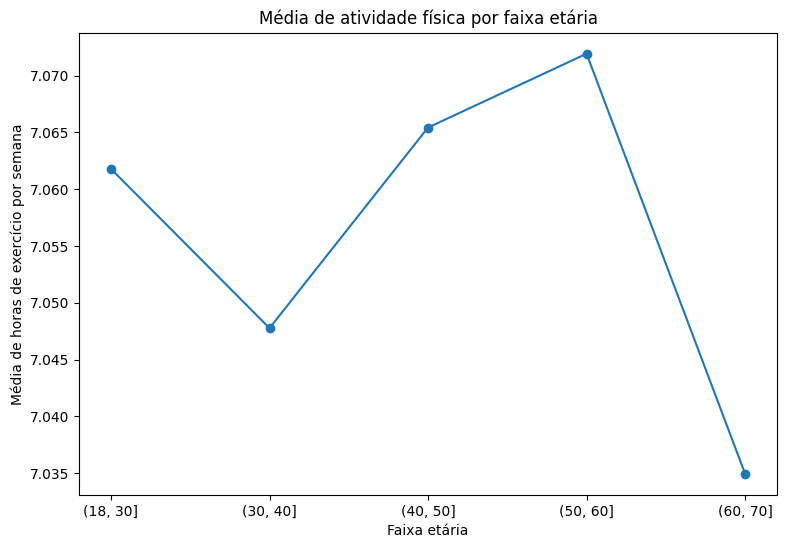

In [68]:
df_silver['faixa_idade'] = pd.cut(
    df_silver['age'],
    bins=[18, 30, 40, 50, 60, 70, 100]
)

media = df_silver.groupby(
    'faixa_idade',
    observed=True
)['exercise_hours_per_week'].mean()

plt.figure(figsize=(9,6))
plt.plot(media.index.astype(str), media.values, marker='o')

plt.xlabel('Faixa etária')
plt.ylabel('Média de horas de exercício por semana')
plt.title('Média de atividade física por faixa etária')

plt.show()

Ao observar o grafico, pode-se perceber que a faixa étaria que mais se destacou como a que mais pratica exercicio fisico é publico entre 50 a 60 anos, isso ocorre devido a serem pessoas com mais tempo livre para praticar atividades fisicas, pode-se observar tambem que o grafico como um todo houve uma redução de 0,1 horas de exercicio, isso se deve a retirada de outliers que puxavam o grafico para cima e tambem o enfoque maior nos paises das americas que aparentam ter pessoas que fazem menos exercicios fisicos que as de outros continentes. 

Ao observar esse grafico pode-se concluir que o melhor publico para as publicidades de exercicios fisicos e relacionados seria o publico  40+ devido a sua alta taxa de exercicio fisico na semana.

## Relação de sendentarismo por faixa étaria 

Para ter uma ideia melhor da porcentagem do publico sedentario, faremos um grafico de barras com porcentagem de sedentarios a fim de descobrir se nosso possivel publico alvo (20 a 40 anos) tem uma margem de sedentarios muito alta, oque poderia ser ruim para nosso projeto

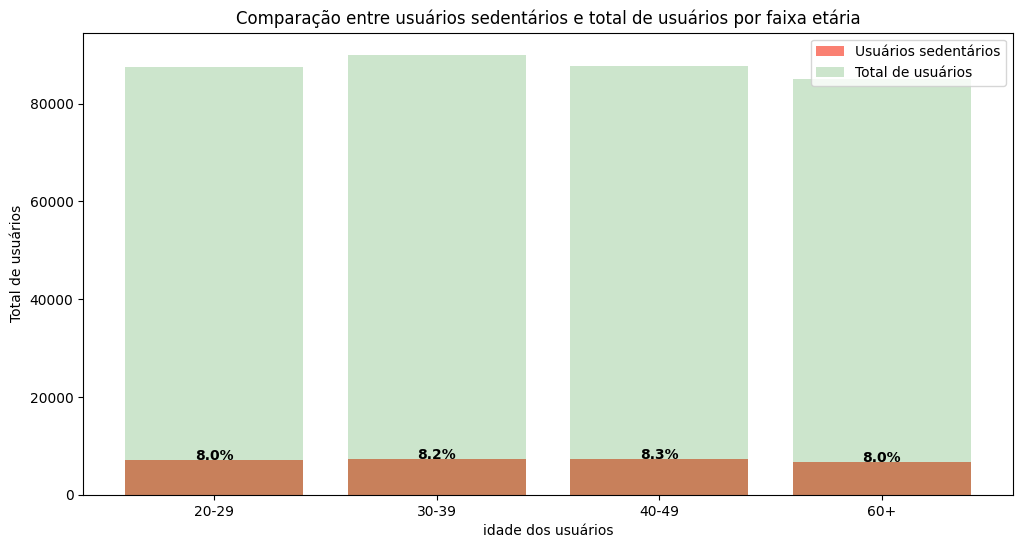

In [36]:
plt.figure(figsize=(12,6))

binsv= [20,30,40,50,60,]
labels = ['20-29','30-39','40-49','60+']

df_silver['age_group'] = pd.cut(df_silver['age'], bins=binsv, labels=labels, right=False)

df_silver['seden'] = df_silver['exercise_hours_per_week'] <= 2
df_silver['seden_total'] = df_silver[df_silver['seden'] == True]['exercise_hours_per_week']
idd_seden = df_silver.groupby('age_group',observed=True)['seden_total'].count() 
per = (idd_seden / df_silver.groupby('age_group',observed=True)['exercise_hours_per_week'].count()) * 100
plt.bar(idd_seden.index, idd_seden.values, color='salmon')
idd_total = df_silver.groupby('age_group',observed=True)['exercise_hours_per_week'].count()
plt.bar(idd_total.index, idd_total.values, color='green', alpha=0.2)
for i, valor_percentual in enumerate(per):
    plt.text(i, idd_seden.values[i] + 1, f'{valor_percentual:.1f}%', 
             ha='center', fontsize=10, fontweight='bold')
plt.xlabel("idade dos usuários") 
plt.ylabel("Total de usuários")
plt.title("Comparação entre usuários sedentários e total de usuários por faixa etária")
plt.legend(['Usuários sedentários', 'Total de usuários'])
plt.show()

Incrivelmente, a porcentagem de sedentarios é quase a mesma para todos os grupos de idades oque é parece ser um cenario ideal para nosso projeto, uma baixa taxa de sedentarismo entre os usuarios.

## Sedentarismo entre os países estudados

Afim de descobrir qual pais poderia possivelmente se interessar menos por anuncios de exercicio fisico, foi feito um grafico a respeito do sedentarismo entre os usuarios agrupado por seu pais de origem.

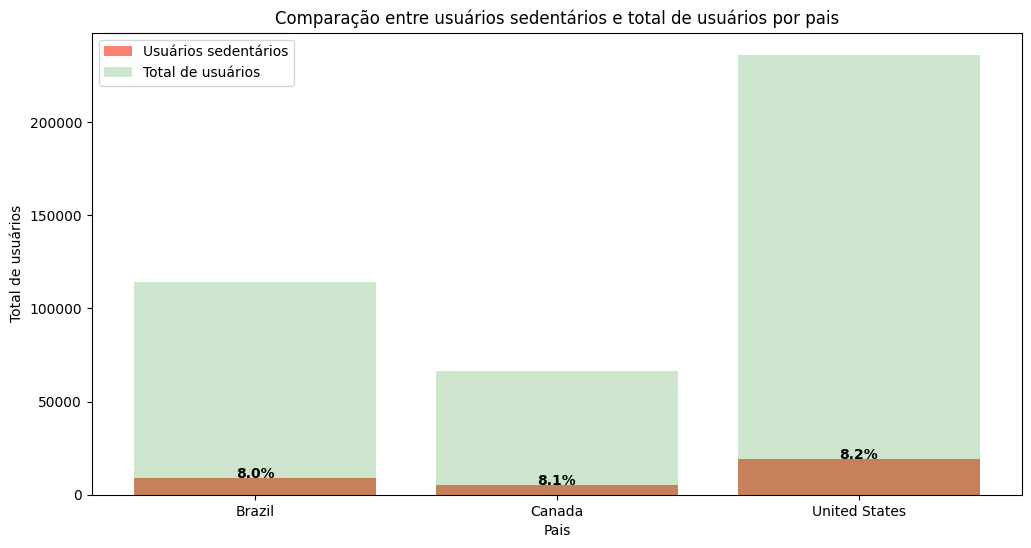

In [39]:
plt.figure(figsize=(12,6))



df_silver['seden'] = df_silver['exercise_hours_per_week'] <= 2
df_silver['seden_total'] = df_silver[df_silver['seden'] == True]['exercise_hours_per_week']
idd_seden = df_silver.groupby('country',observed=True)['seden_total'].count() 
per = (idd_seden / df_silver.groupby('country',observed=True)['exercise_hours_per_week'].count()) * 100
plt.bar(idd_seden.index, idd_seden.values, color='salmon')
idd_total = df_silver.groupby('country',observed=True)['exercise_hours_per_week'].count()
plt.bar(idd_total.index, idd_total.values, color='green', alpha=0.2)
for i, valor_percentual in enumerate(per):
    plt.text(i, idd_seden.values[i] + 1, f'{valor_percentual:.1f}%', 
             ha='center', fontsize=10, fontweight='bold')
plt.xlabel("Pais") 
plt.ylabel("Total de usuários")
plt.title("Comparação entre usuários sedentários e total de usuários por pais")
plt.legend(['Usuários sedentários', 'Total de usuários'])
plt.show()

É possivel perceber que tambem há um padrão entre paises, com numeros baixos de sedentarios.

## Paises que mais clicam em anuncios   

Afim de descobri qual seria o pais que mais teria usuarios interessados em clicar em anuncio foi feito, um grafico mostrando a relação de anuncios clicados pelo pais do usuario

Text(0.5, 1.0, 'Média de anúncios clicados por dia por país')

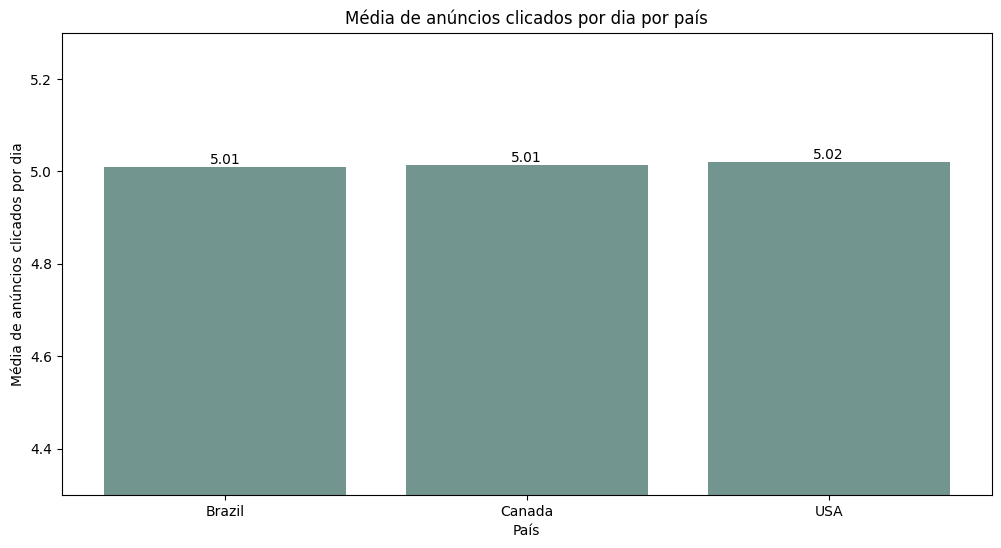

In [43]:
plt.figure(figsize=(12,6))
df_silver['country'] = df_silver['country'].replace({'United Kingdom': 'UK', 'United States': 'USA'})
anum_c = df_silver.groupby('country')['ads_clicked_per_day'].mean()
resul = plt.bar(anum_c.index, anum_c.values, color="#376860", alpha=0.7)
for num in resul:
    height = num.get_height()
    plt.text(
        num.get_x() + num.get_width() / 2,
        height,
        f'{height:1.2f}',
        ha='center',
        va='bottom'
    )
plt.ylim(4.3,5.3)
plt.xlabel("País") 
plt.ylabel("Média de anúncios clicados por dia")
plt.title("Média de anúncios clicados por dia por país")

É possivel perceber um certo padrão no numero de anuncios clicados por dia, oque pode-se concluir que todos os paises onde for feita a divulgação de serviços e produtos relacionados a saude fisica terão aproximadamente o mesmo desempenho. 
É possivel concluir tambem que, ao retirar os dados considerados outliers houve uma aumento do numeros de anuncios assistidos em todos os paises.

## Grafico de cliques em anuncios, por faixa etaria 

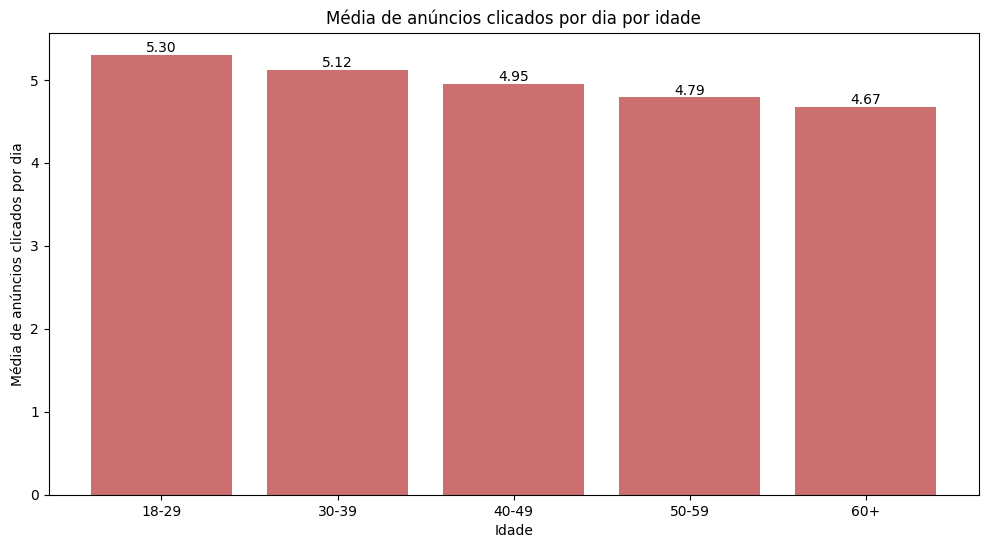

In [67]:
plt.figure(figsize=(12,6))
anum_id = df_silver.groupby('age_group', observed=True)['ads_clicked_per_day'].mean()
resul = plt.bar(anum_id.index, anum_id.values, color="#B73232", alpha=0.7)
for num in resul:
    height = num.get_height()
    plt.text(
        num.get_x() + num.get_width() / 2,
        height,
        f'{height:1.2f}',
        ha='center',
        va='bottom'
    )
plt.xlabel("Idade") 
plt.ylabel("Média de anúncios clicados por dia")
plt.title("Média de anúncios clicados por dia por idade")
plt.show()

Ao observar o grafico, comparado com o mesmo feito na camada raw do projeto, pode ser ver que houve aumentos nas faixas etarias maiores de 40 anos e um diminuição nas faixas étarias menores.

## Grafico de consumo da rede social por pais

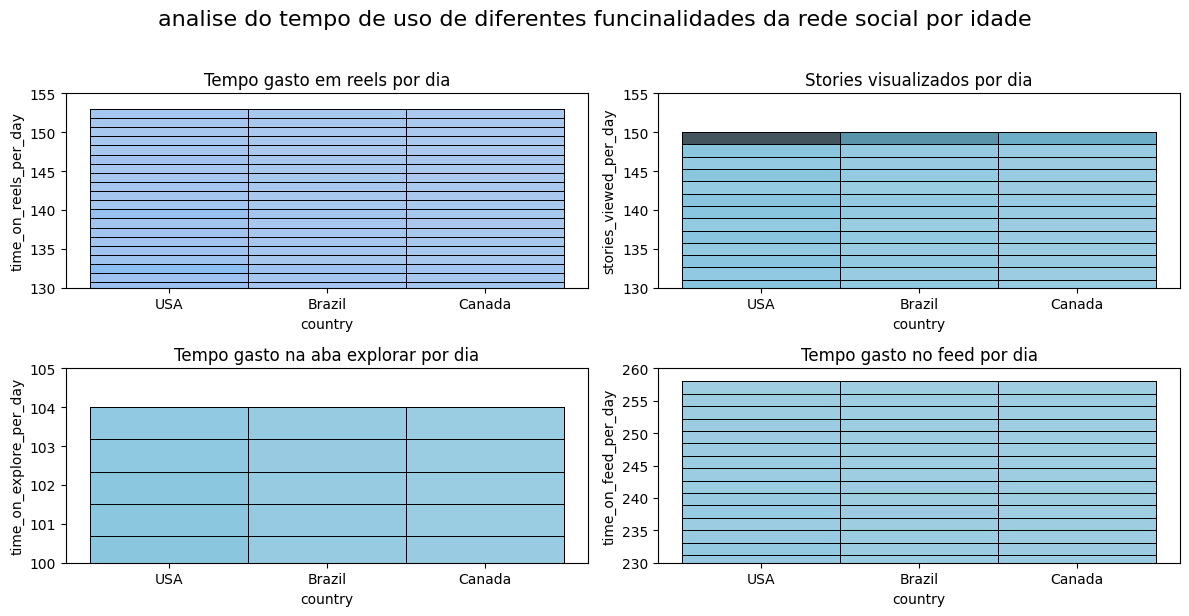

In [59]:
fig = plt.figure(figsize=(12,6))
grid = fig.add_gridspec(2,2)



ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[0,1])
ax3 = fig.add_subplot(grid[1,0])
ax4 = fig.add_subplot(grid[1,1])

graf1 = sns.histplot(x='country', y='time_on_reels_per_day', data=df_silver,ax = ax1,edgecolor= 'black',linewidth=0.5)
graf2 = sns.histplot(x='country', y='stories_viewed_per_day', data=df_silver, color='skyblue',ax = ax2,edgecolor= 'black',linewidth=0.5)
graf3 = sns.histplot(x='country', y='time_on_explore_per_day', data=df_silver, color='skyblue',ax = ax3,edgecolor= 'black',linewidth=0.5)
graf4 = sns.histplot(x='country', y='time_on_feed_per_day', data=df_silver, color='skyblue',ax = ax4,edgecolor= 'black',linewidth=0.5)


graf1.set_ylim(130,155)
graf2.set_ylim(130,155)
graf3.set_ylim(100,105)
graf4.set_ylim(230,260)


graf1.set_title('Tempo gasto em reels por dia')
graf2.set_title('Stories visualizados por dia')
graf3.set_title('Tempo gasto na aba explorar por dia')
graf4.set_title('Tempo gasto no feed por dia')

fig.suptitle('analise do tempo de uso de diferentes funcinalidades da rede social por idade',fontsize=16, y=1.02,x=0.5 )
plt.tight_layout()

É possivel observar uma padronização mais uma vez dos dados encontrados, oque pode-se concluir que os anuncios podem ser feitos em qualquer meio da rede social que eles terão possivelmente o mesmo resultado.

## Tipo de Conteudo mais consumido por cada Faixa étaria

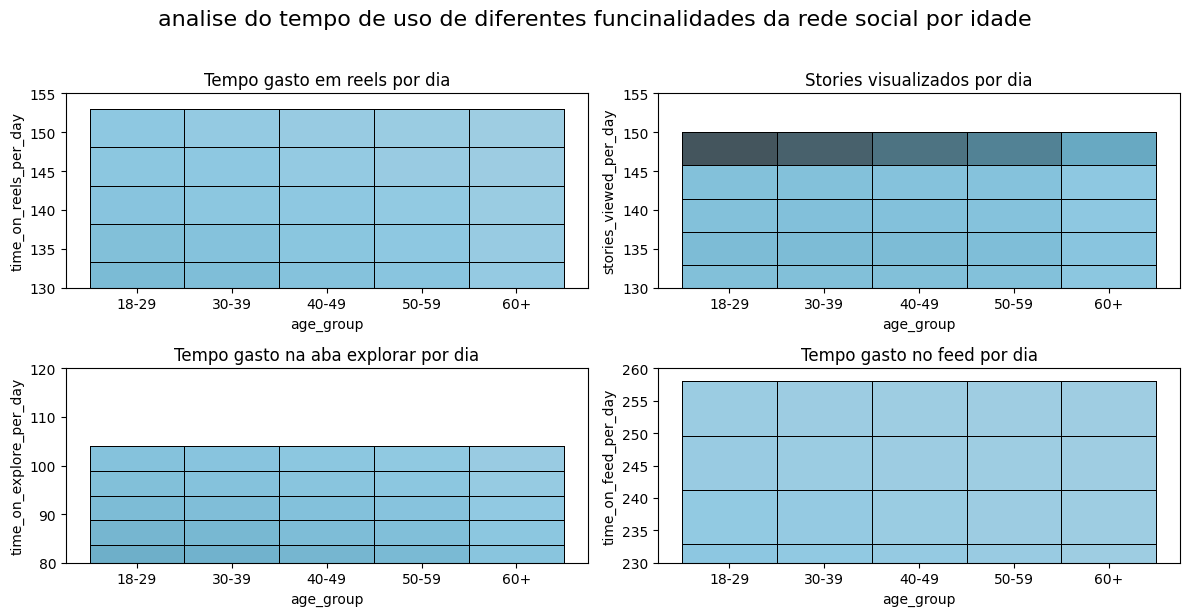

In [ ]:
fig = plt.figure(figsize=(12,6))
grid = fig.add_gridspec(2,2)

binsv= [20,30,40,50,60,70]
labels = ['18-29','30-39','40-49','50-59','60+']

df_silver['age_group'] = pd.cut(df_silver['age'], bins=binsv, labels=labels, right=False)

ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[0,1])
ax3 = fig.add_subplot(grid[1,0])
ax4 = fig.add_subplot(grid[1,1])

graf1 = sns.histplot(x='age_group', y='time_on_reels_per_day', data=df_silver, kde=True, color='skyblue',ax = ax1,bins=30,edgecolor= 'black',linewidth=0.5)
graf2 = sns.histplot(x='age_group', y='stories_viewed_per_day', data=df_silver, kde=True, bins=30, color='skyblue',ax = ax2,edgecolor= 'black',linewidth=0.5)
graf3 = sns.histplot(x='age_group', y='time_on_explore_per_day', data=df_silver, kde=True, bins=20, color='skyblue',ax = ax3,edgecolor= 'black',linewidth=0.5)
graf4 = sns.histplot(x='age_group', y='time_on_feed_per_day', data=df_silver, kde=True, bins=30, color='skyblue',ax = ax4,edgecolor= 'black',linewidth=0.5)


graf1.set_ylim(130,155)
graf2.set_ylim(130,155)
graf3.set_ylim(80,120)
graf4.set_ylim(230,260)


graf1.set_title('Tempo gasto em reels por dia')
graf2.set_title('Stories visualizados por dia')
graf3.set_title('Tempo gasto na aba explorar por dia')
graf4.set_title('Tempo gasto no feed por dia')

fig.suptitle('analise do tempo de uso de diferentes funcinalidades da rede social por idade',fontsize=16, y=1.02,x=0.5 )
plt.tight_layout()

É possivel observar que, com a retirada de outliers e uma  especificação maior dos paises estudados houuve uma padronização mais uma vez dos dados encontrados, oque pode-se concluir que os anuncios podem ser feitos em qualquer meio da rede social que eles terão possivelmente o mesmo resultado.

## quantidade de usuarios interessados em conteudo fitness, por faixa étaria

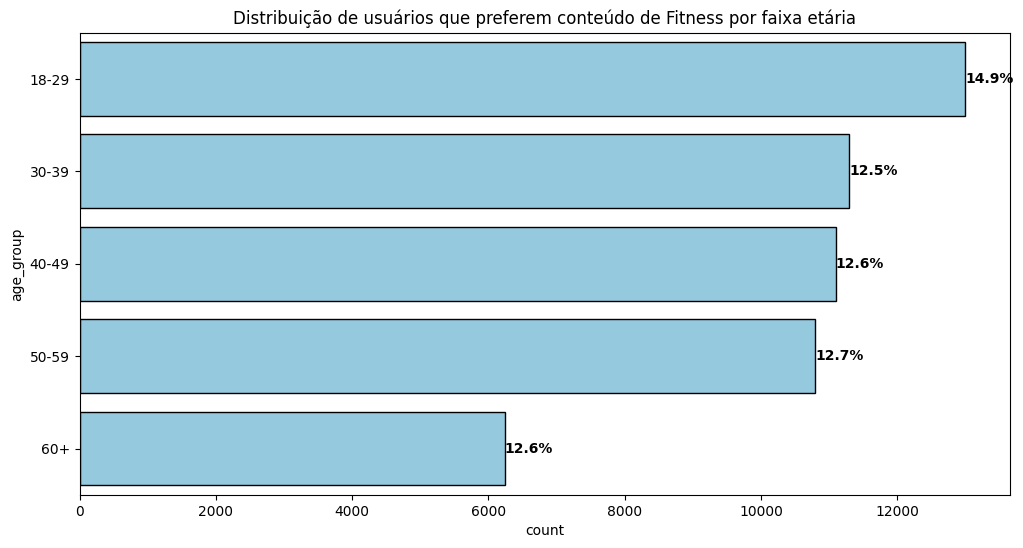

In [88]:
plt.figure(figsize=(12,6))
df_fit = df_silver[df_silver['preferred_content_theme'] == 'Fitness'].copy()

binsv = [18, 30, 40, 50, 60, 70]
labels = ['18-29', '30-39', '40-49', '50-59', '60+']
df_fit['age_group'] = pd.cut(df_fit['age'], bins=binsv, labels=labels, right=False)

contagem_fit = df_fit['age_group'].value_counts().sort_index()
contagem_total = df_silver['age_group'].value_counts().sort_index()
porcentagens = (contagem_fit / contagem_total) * 100

for i, label in enumerate(labels):
    qtd = contagem_fit[label]
    pct = porcentagens[label]
    plt.text(qtd + 5, i, f'{pct:.1f}%', va='center', fontsize=10, fontweight='bold')
    
sns.countplot(y='age_group', data=df_fit, color='skyblue', edgecolor='black', linewidth=1)
plt.title('Distribuição de usuários que preferem conteúdo de Fitness por faixa etária')

plt.show()

É possivel ver um grande interesse dos jovens no conteudo fit, oque pode indicar de eles serem otimos publicos alvo para anuncios sobre o conteudo fit

## quatidade de usuarios interessados no conteudo fitness, por pais

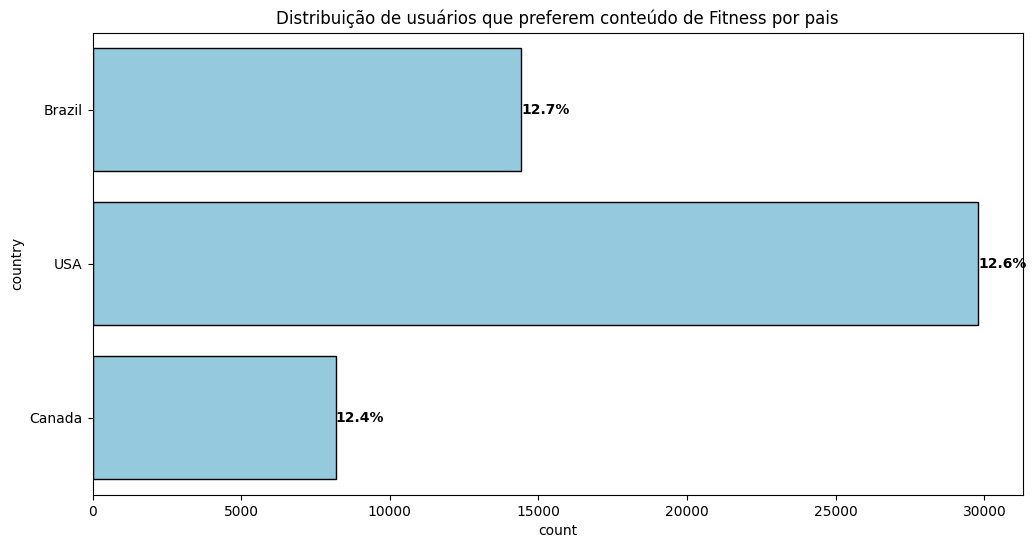

In [92]:
plt.figure(figsize=(12,6))
df_fit = df_silver[df_silver['preferred_content_theme'] == 'Fitness'].copy()

contagem_fit = df_fit['country'].value_counts().sort_index()
contagem_total = df_silver['country'].value_counts().sort_index()
porcentagens = (contagem_fit / contagem_total) * 100



ax = sns.countplot(y='country', data=df_fit, color='skyblue', edgecolor='black', linewidth=1)

paises_no_grafico = [label.get_text() for label in ax.get_yticklabels()]
for i, nome_pais in enumerate(paises_no_grafico):
    qtd = contagem_fit[nome_pais]
    pct = porcentagens[nome_pais]
    plt.text(qtd + 1, i, f'{pct:.1f}%', va='center', fontsize=10, fontweight='bold')
plt.title('Distribuição de usuários que preferem conteúdo de Fitness por pais')

plt.show()

Por mais que a maioria tenha um numero bastante parecido, o pais que mais se destaca é o brasil oque pode indicar dele ser um bom alvo de publicidade sobre o assunto fit